### Instructions
It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.<br>
<br>
The experiments you did with the Spotify API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

- Check whether or not the song is in the Billboard Hot 200.
- Collect the audio features from the Spotify API.

After that, you want to send the Spotify audio features of the submitted song to the clustering model, which should return a cluster number.<br>
<br>
We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

### Import libraries and load dataframes

In [1]:
import pandas as pd
import numpy as np
import os

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances_argmin_min

In [2]:
billboard = pd.read_csv("billboard_songs.csv")
billboard.head()

,title,artist
0,Last Night,Morgan Wallen
1,Fast Car,Luke Combs
2,Calm Down,Rema & Selena Gomez
3,Flowers,Miley Cyrus
4,All My Life,Lil Durk Featuring J. Cole


In [3]:
spotipy_songs = pd.read_csv("audio_features_songs.csv")
spotipy_songs.head()

,id,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2UW7JaomAMuX9pZrjVpHAU,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,2,-5.678,0,0.3330,0.2130,0.000001,0.0756,0.559,169.922,234353,4
1,7ro0hRteUMfnOioTFI5TG1,WHERE SHE GOES,Bad Bunny,0.652,0.800,9,-4.019,0,0.0614,0.1430,0.629000,0.1120,0.234,143.978,231704,4
2,5TMLavqGRKNxgzMBrVpC9R,Mon Amour - Remix,"zzoilo, Aitana",0.748,0.761,2,-6.621,1,0.1020,0.1220,0.000007,0.0984,0.362,116.041,179940,4
3,0Be7sopyKMv8Y8npsUkax2,Tacones Rojos,Sebastian Yatra,0.748,0.856,11,-3.517,0,0.0348,0.0824,0.000000,0.1420,0.927,123.031,189320,4
4,7FbrGaHYVDmfr7KoLIZnQ7,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,11,-8.332,0,0.0331,0.4350,0.000004,0.3470,0.726,120.018,174253,4


In [4]:
kaggle_songs = pd.read_csv("kaggle_spotify_data.csv")
kaggle_songs.head()

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,mode,key,popularity,explicit
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,0.100,-11.803,0.0328,125.898,0.547,1,9,26,0
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,0.159,-11.605,0.0306,150.166,0.338,1,8,21,0
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,0.946,-9.728,0.0505,143.079,0.279,1,8,41,0
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,37,0
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,0.183,-9.315,0.0307,150.316,0.310,1,8,35,0


### Cleaning and some exploration of the Kaggle dataframe
Dataframe downloaded from https://www.kaggle.com/datasets/fcpercival/160k-spotify-songs-sorted

In [5]:
kaggle_songs.shape

(169907, 19)

In [6]:
kaggle_songs.isna().sum()

id                  0
name                0
artists             0
duration_ms         0
release_date        0
year                0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
mode                0
key                 0
popularity          0
explicit            0
dtype: int64

In [8]:
kaggle_songs.columns

Index(['id', 'name', 'artists', 'duration_ms', 'release_date', 'year',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit'],
      dtype='object')

In [9]:
spotipy_songs.columns

Index(['id', 'title', 'artist', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [5]:
# Drop columns that are only in one of the dataframes
# Drop "id" column since we are not going to use it
# Also drop "liveness" because it only measures if a  was performed live or through a recording studio (not an element of the music itself)

kaggle_songs = kaggle_songs.drop(['id', 'release_date', 'year', 'popularity', 'explicit', 'liveness'], axis=1)
spotipy_songs = spotipy_songs.drop(['id', 'time_signature', 'liveness'], axis=1)

More info about the meaning of each column: https://github.com/gabminamedez/spotify-data

In [6]:
# Check that both dataframes have the same number of columns

kaggle_songs.shape, spotipy_songs.shape

((169907, 13), (883, 13))

In [7]:
# Rename columns to have the same names in both dataframes

kaggle_songs.columns = ['title', 'artist', 'duration_ms', 'acousticness', 'danceability', 
                        'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 
                        'valence', 'mode', 'key']

In [8]:
# Reorder columns

kaggle_songs = kaggle_songs[['title', 'artist', 'danceability', 'energy', 'key', 'loudness',
                             'mode', 'speechiness', 'acousticness', 'instrumentalness', 'valence',
                             'tempo', 'duration_ms']]

In [9]:
# Remove extra characters in the artist column

kaggle_songs["artist"] = kaggle_songs["artist"].apply(lambda x: x[2:-2])
kaggle_songs.head()

,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms
0,!Que Vida! - Mono Version,Love,0.600,0.540,9,-11.803,1,0.0328,0.5250,0.00305,0.547,125.898,220560
1,"""40""",U2,0.368,0.480,8,-11.605,1,0.0306,0.2280,0.70700,0.338,150.166,157840
2,"""40"" - Live",U2,0.272,0.684,8,-9.728,1,0.0505,0.0998,0.01450,0.279,143.079,226200
3,"""40"" - Remastered 2008",U2,0.371,0.545,8,-9.315,1,0.0307,0.1850,0.58200,0.310,150.316,157667
4,"""40"" - Remastered 2008",U2,0.371,0.545,8,-9.315,1,0.0307,0.1850,0.58200,0.310,150.316,157667


### Concatenate the two dataframes

In [10]:
audio_features_songs = pd.concat([spotipy_songs, kaggle_songs]).reset_index(drop=True)
audio_features_songs.sample(10)

,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms
166551,"sincerely, yours",Nohidea,0.605,0.396,5,-11.301,0,0.0509,0.800,0.872000,0.6220,80.957,139684
74894,Kevin’s Heart,J. Cole,0.829,0.527,6,-6.644,0,0.3670,0.482,0.000000,0.4730,116.078,200310
93790,"Mozart: Violin Concerto No. 5 in A Major, K. 2...","Wolfgang Amadeus Mozart', 'Karl Böhm', 'Staats...",0.250,0.181,4,-17.617,1,0.0436,0.947,0.077600,0.1410,132.546,581013
49081,Generals,The Damned,0.437,0.953,2,-5.845,1,0.0519,0.132,0.000000,0.5950,168.023,203455
76063,Krazy World,King Geedorah,0.412,0.816,5,-1.987,1,0.1040,0.091,0.000000,0.7480,95.752,283920
25029,Cheliya Kanaraava,Akkineni Nageswara Rao,0.606,0.257,1,-15.581,1,0.0586,0.993,0.369000,0.7960,67.970,155333
34125,"Die Liebe der Danae, Op. 83, TrV 278, Act III:...","Richard Strauss', 'Annelies Kupper', 'Josef Go...",0.159,0.196,8,-20.040,0,0.0532,0.974,0.002580,0.0773,77.874,369933
67249,If It's Over,Mariah Carey,0.532,0.456,9,-9.673,1,0.0305,0.393,0.000002,0.2000,92.759,277093
97445,Ney Taksimi,Mehmet Kemiksiz,0.269,0.143,4,-9.003,1,0.0413,0.970,0.469000,0.4100,141.386,86988
162126,Work,Thelonious Monk,0.347,0.663,1,-11.730,1,0.0755,0.734,0.334000,0.7260,175.757,317200


In [11]:
# Check duplicates 

audio_features_songs.duplicated().value_counts()

False    166906
True       3884
dtype: int64

In [12]:
audio_features_songs = audio_features_songs.drop_duplicates()
audio_features_songs.duplicated().value_counts()

False    166906
dtype: int64

In [13]:
audio_features_songs.to_csv("audio_features_songs_final.csv", index=False)

### Preprocessing the data before clustering with Kmeans

In [14]:
# Scale the numeric data to a range between 0 and 1 with MinMaxScaler (because Kmeans is based in distances)

X = audio_features_songs.select_dtypes(np.number)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms
0,0.821862,0.479,0.181818,0.850709,0.0,0.343653,0.213855,0.000001,0.559,0.696142,0.042465
1,0.659919,0.800,0.818182,0.876689,0.0,0.063364,0.143574,0.629000,0.234,0.589854,0.041975
2,0.757085,0.761,0.181818,0.835941,1.0,0.105263,0.122490,0.000007,0.362,0.475401,0.032386
3,0.757085,0.856,1.000000,0.884551,0.0,0.035913,0.082731,0.000000,0.927,0.504037,0.034123
4,0.792510,0.592,1.000000,0.809146,0.0,0.034159,0.436747,0.000004,0.726,0.491694,0.031332


In [20]:
X_scaled.to_csv("X_scaled.csv", index=False)

### Clustering with Kmeans

**Find the optimum k (number of clusters) by looking at different metrics (inertia and silhouette score).** <br>
By intuition, there should be at least more than 5 clusters, to be able to recognize songs from different music styles.

In [17]:
K = range(5, 15)

inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=1234)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

inertia

[389974922617248.94,
 287507686517290.3,
 219405598750377.66,
 172938730791358.2,
 138099875313208.03,
 112505785405664.88,
 92753113589700.25,
 79148566588930.33,
 68079000394081.42,
 58869102584097.65]

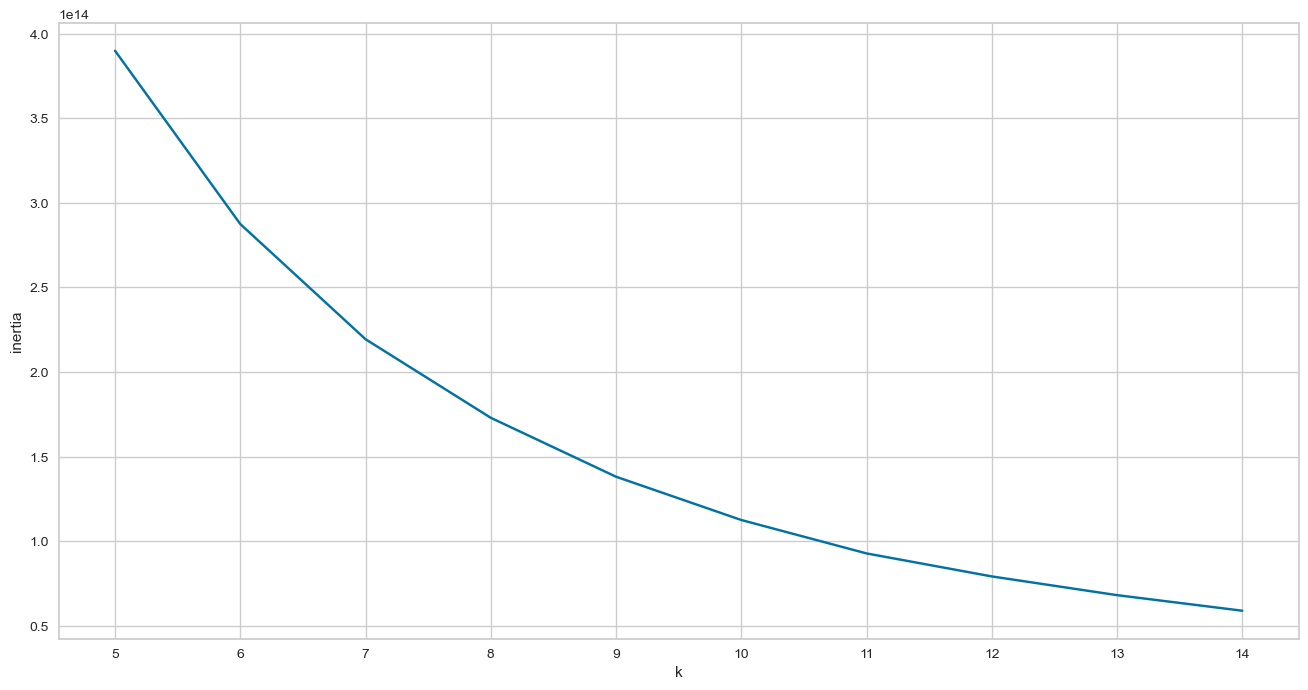

In [18]:
# Plot to see where is the "elbow"

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

It's difficult to see the elbow here, perhaps 6-7.

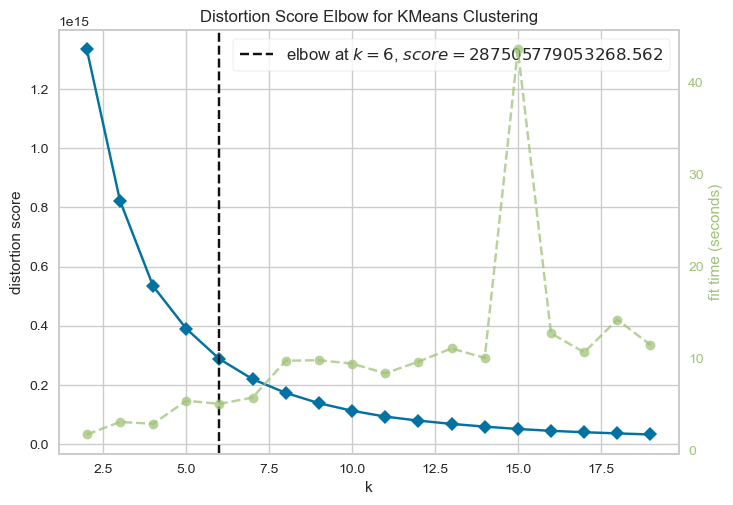

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
model = KMeans(max_iter=100, random_state=1234)
visualizer = KElbowVisualizer(model, k=(2,20))

visualizer.fit(X)    
visualizer.poof()    

By using Yellowbrick, we see that the elbow would be at k=6.

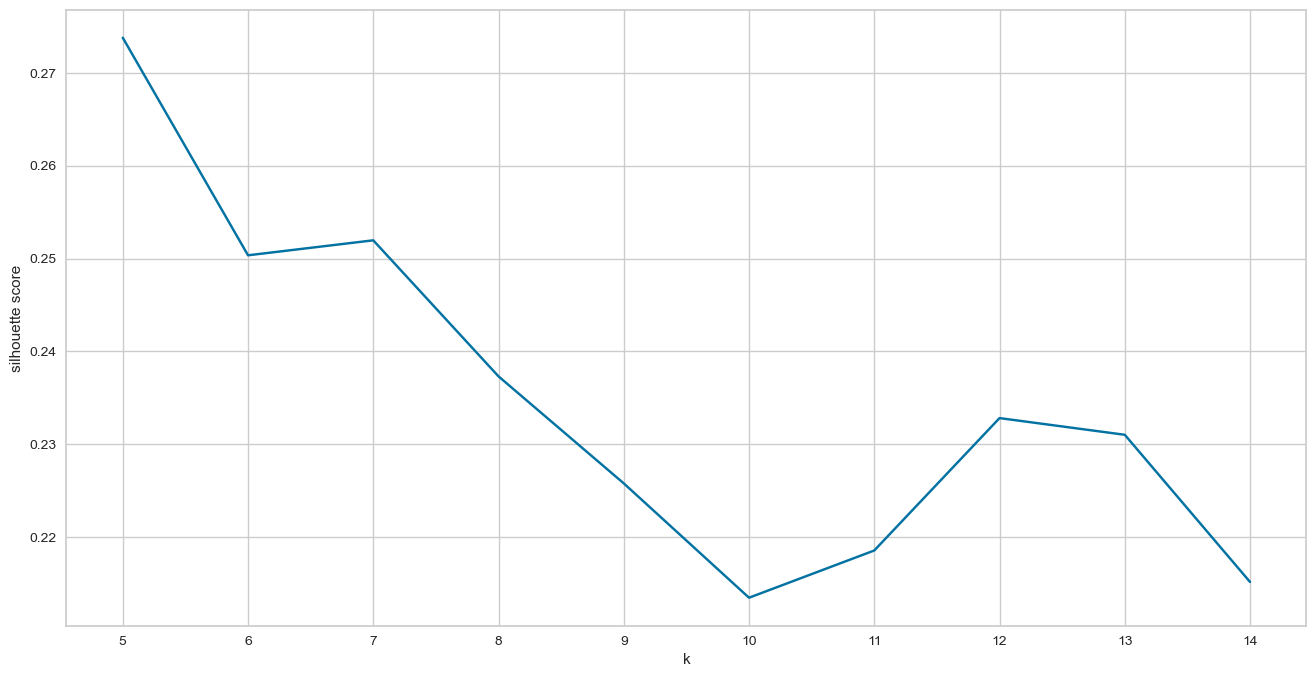

In [27]:
K = range(5, 15)

silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=1234)
    kmeans.fit(X_scaled)
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.show()

5 or 7 are a good choice, also 12 if we wanted more clusters.

IndexError: index 2 is out of bounds for axis 0 with size 2

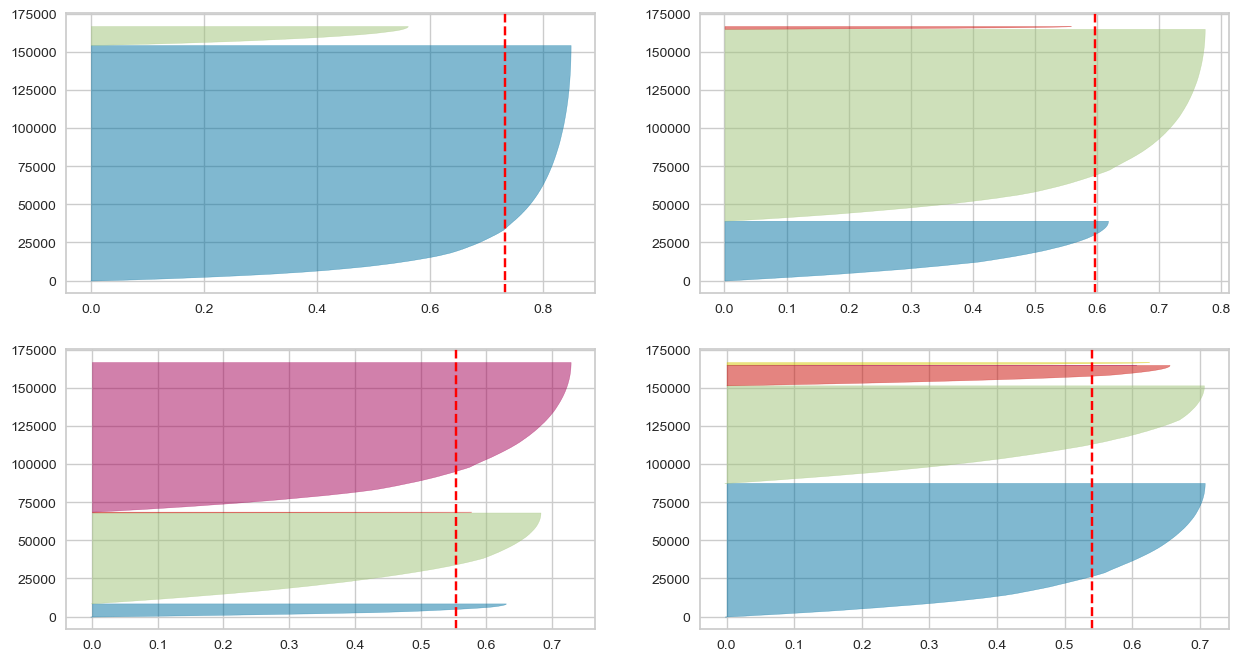

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(2, 10):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

IndexError: index 2 is out of bounds for axis 0 with size 2

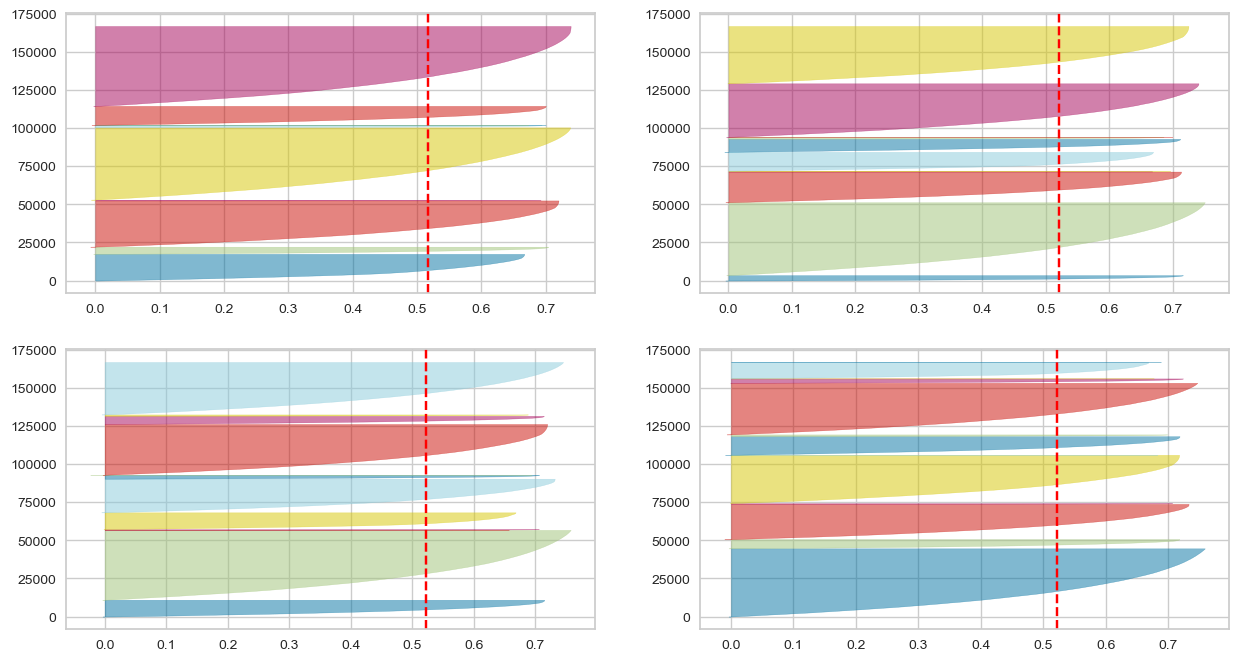

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in range(10, 20):
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-5][mod])
    visualizer.fit(X)

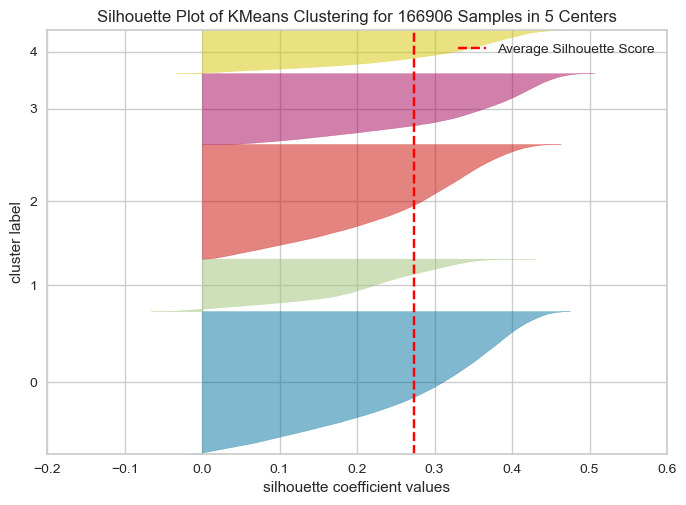

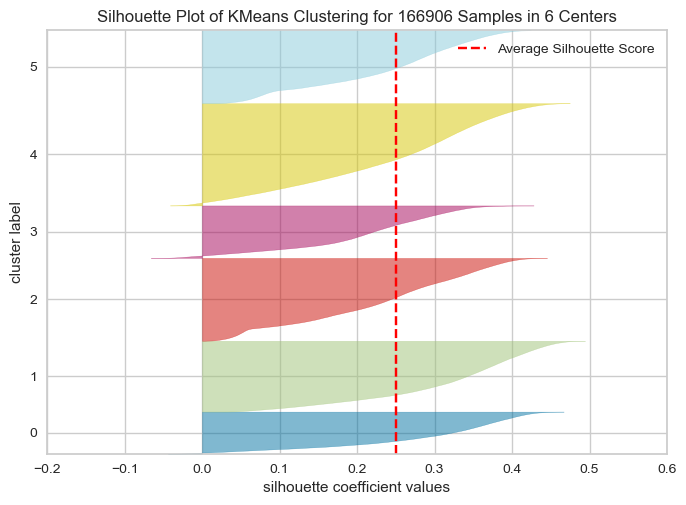

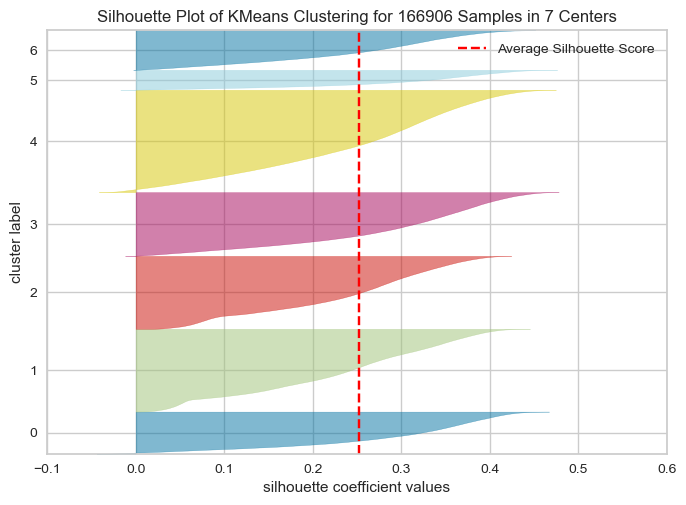

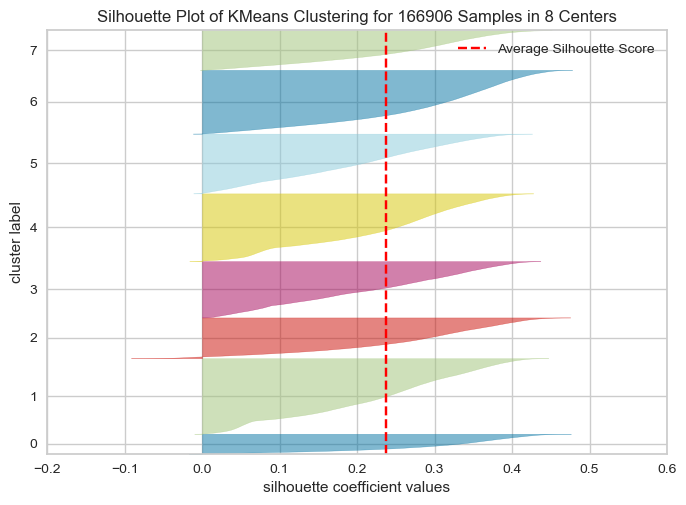

KeyboardInterrupt: 

In [28]:
for i in range(5, 15):
    model = KMeans(i, max_iter=100, random_state=1234)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')

    visualizer.fit(X_scaled)        
    visualizer.show() 

**Visualize the results** <br>
In order to plot the results we need to transform the 11 features into just 2. For that purpose we will apply PCA.

In [15]:
pca = PCA(2) 
X_2D = pca.fit_transform(X_scaled)
X_2D

array([[-0.54304157,  0.50040539],
       [-0.47726199,  0.6684501 ],
       [-0.31529055, -0.46251331],
       ...,
       [-0.70187248,  0.55117613],
       [-0.73356179,  0.54930256],
       [ 0.1163187 , -0.31189693]])

In [29]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_2D)
clusters = kmeans.predict(X_2D)
clusters

array([0, 0, 2, ..., 0, 0, 1])

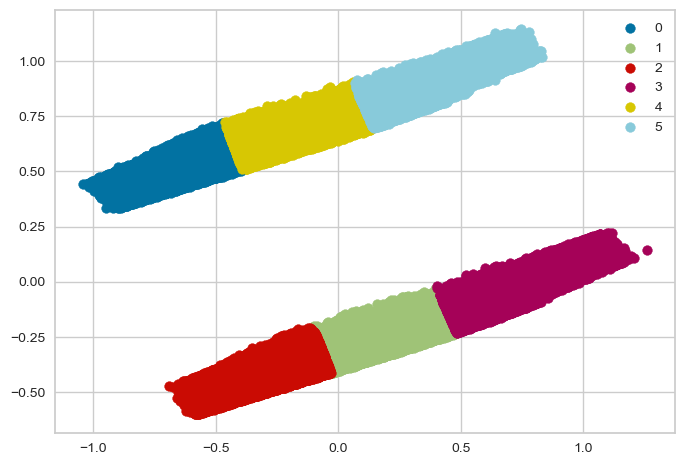

In [30]:
labels = np.unique(clusters)

for i in labels:
    plt.scatter(X_2D[clusters == i , 0] , X_2D[clusters == i , 1] , label = i)
plt.legend()
plt.show()

**Assign clusters to original dataframe**

In [31]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_scaled)
clusters = kmeans.predict(X_scaled)
clusters

array([4, 4, 1, ..., 4, 4, 1])

In [32]:
score = silhouette_score(X_scaled, kmeans.labels_, metric='euclidean')
score

0.25033934329230506

In [19]:
songs_clusters = audio_features_songs.copy()
songs_clusters["cluster"] = clusters
songs_clusters.head()

,title,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,valence,tempo,duration_ms,cluster
0,La Bebe - Remix,"Yng Lvcas, Peso Pluma",0.812,0.479,2,-5.678,0,0.3330,0.2130,0.000001,0.559,169.922,234353,1
1,WHERE SHE GOES,Bad Bunny,0.652,0.800,9,-4.019,0,0.0614,0.1430,0.629000,0.234,143.978,231704,1
2,Mon Amour - Remix,"zzoilo, Aitana",0.748,0.761,2,-6.621,1,0.1020,0.1220,0.000007,0.362,116.041,179940,2
3,Tacones Rojos,Sebastian Yatra,0.748,0.856,11,-3.517,0,0.0348,0.0824,0.000000,0.927,123.031,189320,1
4,Cupid - Twin Ver.,FIFTY FIFTY,0.783,0.592,11,-8.332,0,0.0331,0.4350,0.000004,0.726,120.018,174253,1


In [20]:
songs_clusters["cluster"].value_counts()

2    56183
3    45194
1    27911
4    20697
0    16921
Name: cluster, dtype: int64

In [21]:
songs_clusters.to_csv("songs_clusters.csv", index=False)

### Build the recommender
Logic:
- Ask the user for a song (title + artist)
- Check if the song is in "billboard"
- If yes: return another random song from "billboard"
- If no: 
    - Use spotipy to obtain audio features from the song
    - Apply Kmeans to asign a cluster to the song
    - Return a song from "songs_clusters" that belongs to the same cluster

In [23]:
client_id = os.getenv('spotify_id')
client_secret = os.getenv('spotify_secret')

In [24]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id, client_secret))

In [ ]:
user_title = input("Please enter the title of the song: ")
user_artist = input("Please enter the artist: ")

In [25]:
def recommend_song(title, artist):
    
    # If the user input is a song in the Billboard list, recommend another song from the list
    if title in billboard["title"].unique():
        if artist in list(billboard.loc[billboard["title"] == title, "artist"]):
            while True:
                recommendation = billboard.sample(1, ignore_index=True)
                if recommendation["title"][0] != title or recommendation["artist"][0] != artist:
                    return ' - '.join([recommendation["title"][0], recommendation["artist"][0]])
                    break

    # If it's not in the Billboard list, try to find the song in Spotipy, if not return an error message
    elif sp.search(q=f"track:{title}", limit=1)["tracks"]["total"] == 0:
        print("Could not find the song")

    # When the song is in Spotipy, search for a similar song by clustering
    else:

        # Obtain audio features of the user song
        results = sp.search(q=f"track:{title}", limit=1)
        track_id = results["tracks"]["items"][0]["id"]
        audio_features = sp.audio_features(track_id)

        # Create dataframe
        df = pd.DataFrame(audio_features)
        new_features = df[X.columns]

        # Scale features
        X_scaled = MinMaxScaler().fit_transform(new_features)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

        # Predict cluster
        cluster = kmeans.predict(X_scaled)

        # Filter the dataframe to select only the predicted cluster
        filtered_df = songs_clusters[songs_clusters["cluster"] == cluster[0]]

        # Get one random song from the filtered dataframe
        recommendation = filtered_df.sample(1, ignore_index=True)
        return ' - '.join([recommendation["title"][0], recommendation["artist"][0]])

In [ ]:
# The initial idea was to get the closest song, but there's an error and it returns only one song for each cluster

#         # Filter the dataframe to select only the predicted cluster
#         filtered_df = songs_clusters[songs_clusters["cluster"] == cluster[0]][X.columns]

#         # Get the index of the closest song from the filtered dataframe
#         closest, _ = pairwise_distances_argmin_min(X_scaled, filtered_df)

#         # Return the closest song
#         return ' - '.join(
#             [songs_clusters.loc[closest]["title"].values[0], songs_clusters.loc[closest]["artist"].values[0]])

In [26]:
recommend_song("La bomba", "King Africa")

'A Day In The Park - Michal Urbaniak'

### Conclusion
We have built a song recommender that receives the user input and, if it's a song that is popular (appears in the Billboard top 100), returns also a popular song. If it's not, it returns a similar song from a dataset of 166,906 unique songs and their audio features. For that purpose, this dataset has been divided in 6 clusters using Kmeans. The recommender searches the audio features of the user's song, it asigns the song to a cluster, and then selects a random song from the same cluster in the dataset. It also returns an error message if the song is not recognized. <br>
This is an MVP. Next steps for improvement:
- Kmeans: better adjustment of the number of clusters, hyperparameter tuning.
- Try with other clustering models like DBSCAN or Gaussian Mixtures.
- Instead of returning a random song from the same cluster, return the closest song (which was the initial idea, but there was not enough time to make it work)